## Dev environment for plot routines

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [7]:
from argparse import Namespace
import joblib as jl

from kpsn_test.routines.util import load_cfg, save_results, update, find_file

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plot_dir = '../../plots/notebook/plot_routines'

### Setup

In [105]:
args = Namespace(
    results_fmt = '../../results/lra/blscale_modellock-morph/{}.jl',
    output_fmt = '/tmp/{}.png',
    savefig_cfg = None,
    path = ('../../results/lra/blscale_base/{}.jl',)
)

In [106]:
if len(args.path) == 1:
    override_paths = None
    fallback_fmt = args.path[0]
else:
    override_paths = {
        args.path[2*i]: args.path[2*i + 1]
        for i in range(len(args.path) // 2)}
    fallback_fmt = None

load = lambda key: jl.load(find_file(
    key, args.results_fmt, override_paths, fallback_fmt))


dataset = load('dataset')
init = load('init')
fit = load('fit')
print("Loaded data.")

results = dict(
    dataset = dataset,
    init = init,
    fit = fit)

savefig_cfg = update(dict(
    dpi = 300
    ), load_cfg(args.savefig_cfg))
savefig = lambda fmt, fig: save_results(
    args.output_fmt, fmt,
    lambda path: fig.savefig(path, **savefig_cfg))

Loaded data.


### Bone lengths over training

In [56]:
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import linear_skeletal as ls
from kpsn.util import skeleton
from kpsn_test import visualize as viz
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
dataset = results['dataset']
fit = results['fit']
cfg = dict(
    stepsize = 2,
    reroot = 'hips',
    groupby = 'tgt_age',
    ref_sess = 0)

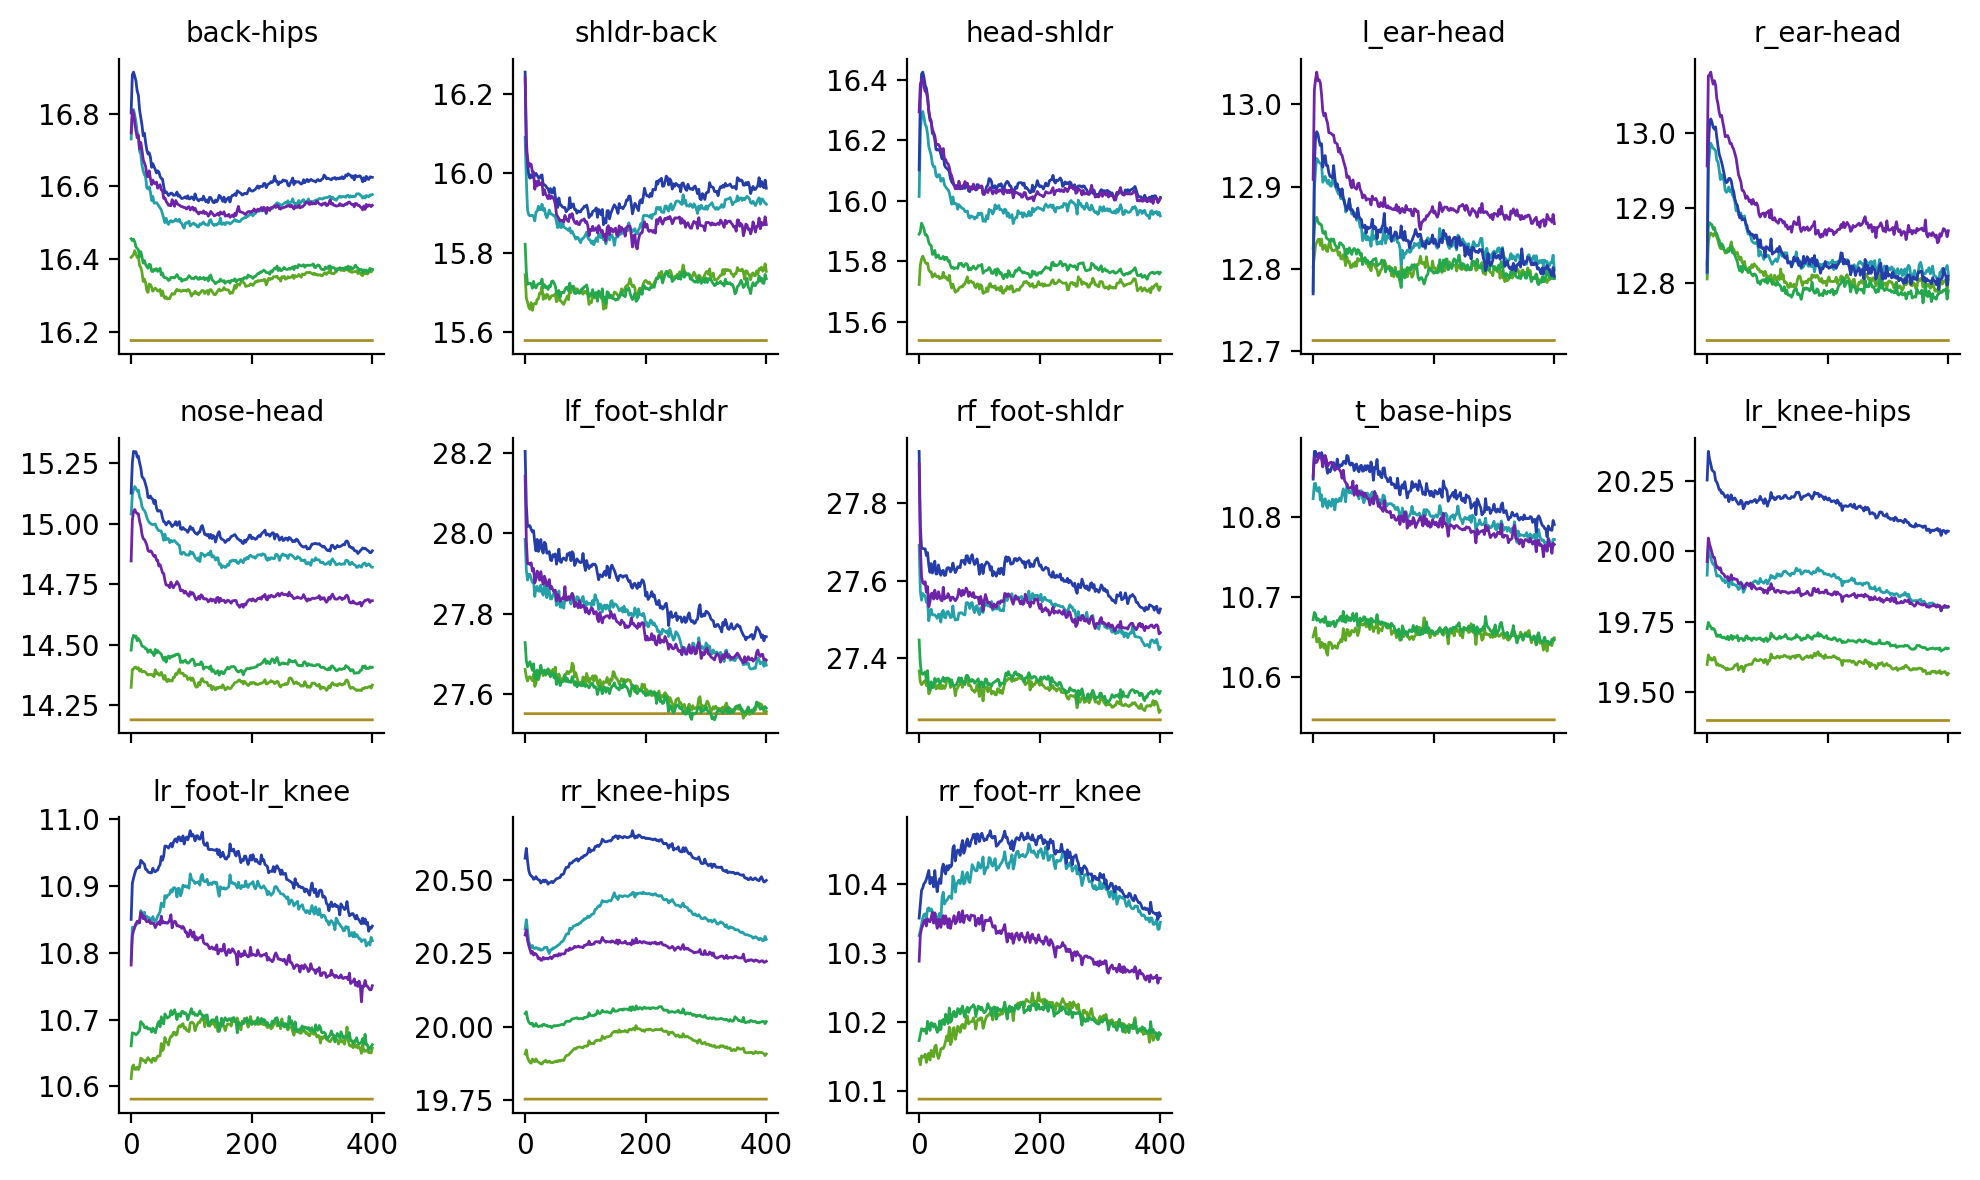

In [58]:
morph_model = afm.AffineModeMorph
skel = skeleton.default_armature
if cfg['reroot'] is not None:
    skel = skeleton.reroot(skel, cfg['reroot'])
ls_mat = ls.construct_transform(skel, skel.keypt_by_name[skel.root])

metadata = dataset['metadata']
sessions = metadata['session_ix'].keys()
mean_lengths = {sess_name: [] for sess_name in sessions}
steps = np.arange(0, len(fit['param_hist']), cfg['stepsize'])
for step_i in steps:
    params = fit['param_hist'][step_i].with_hyperparams(fit['fit_params'].hyperparams)
    poses = morph_model.inverse_transform(
        params.morph,
        dataset['keypts'],
        dataset['subject_ids'])
    keypts = morph_model.transform(
        params.morph, poses, np.full([len(poses)], cfg['ref_sess']))
    
    all_roots, all_bones = ls.transform(
        keypts.reshape([-1, skel.n_kpts, 3]), ls_mat)
    all_lengths = np.linalg.norm(all_bones, axis = -1)
    for sess_name in sessions:
        slc = metadata['session_slice'][sess_name]
        mean_lengths[sess_name].append(all_lengths[slc].mean(axis = 0))
mean_lengths = {k: np.array(v) for k, v in mean_lengths.items()}

age_pal = viz.defaults.age_pal(metadata[cfg['groupby']])
fig, axes = viz.struct.flat_grid(len(skel.bones), 5, ax_size = (2, 2), 
    subplot_kw = dict(sharex = True, sharey = False))
for i_bone, ax in enumerate(axes):
    for sess_name in sessions:
        ax.plot(
            steps, mean_lengths[sess_name][:, i_bone],
            lw = 1,
            color = age_pal[metadata[cfg['groupby']][sess_name]])
    ax.set_title(skel.bone_name(i_bone), fontsize = 10)
sns.despine()
plt.tight_layout()
plt.show()


### Mode & offset over training

In [27]:
from kpsn.models import pose
from kpsn.util import keypt_io

In [28]:
dataset = results['dataset']
fit = results['fit']
init = results['init']
cfg = dict(
    groupby = 'tgt_age',)

Reloading 'kpsn_test.visualize.affine_mode'.


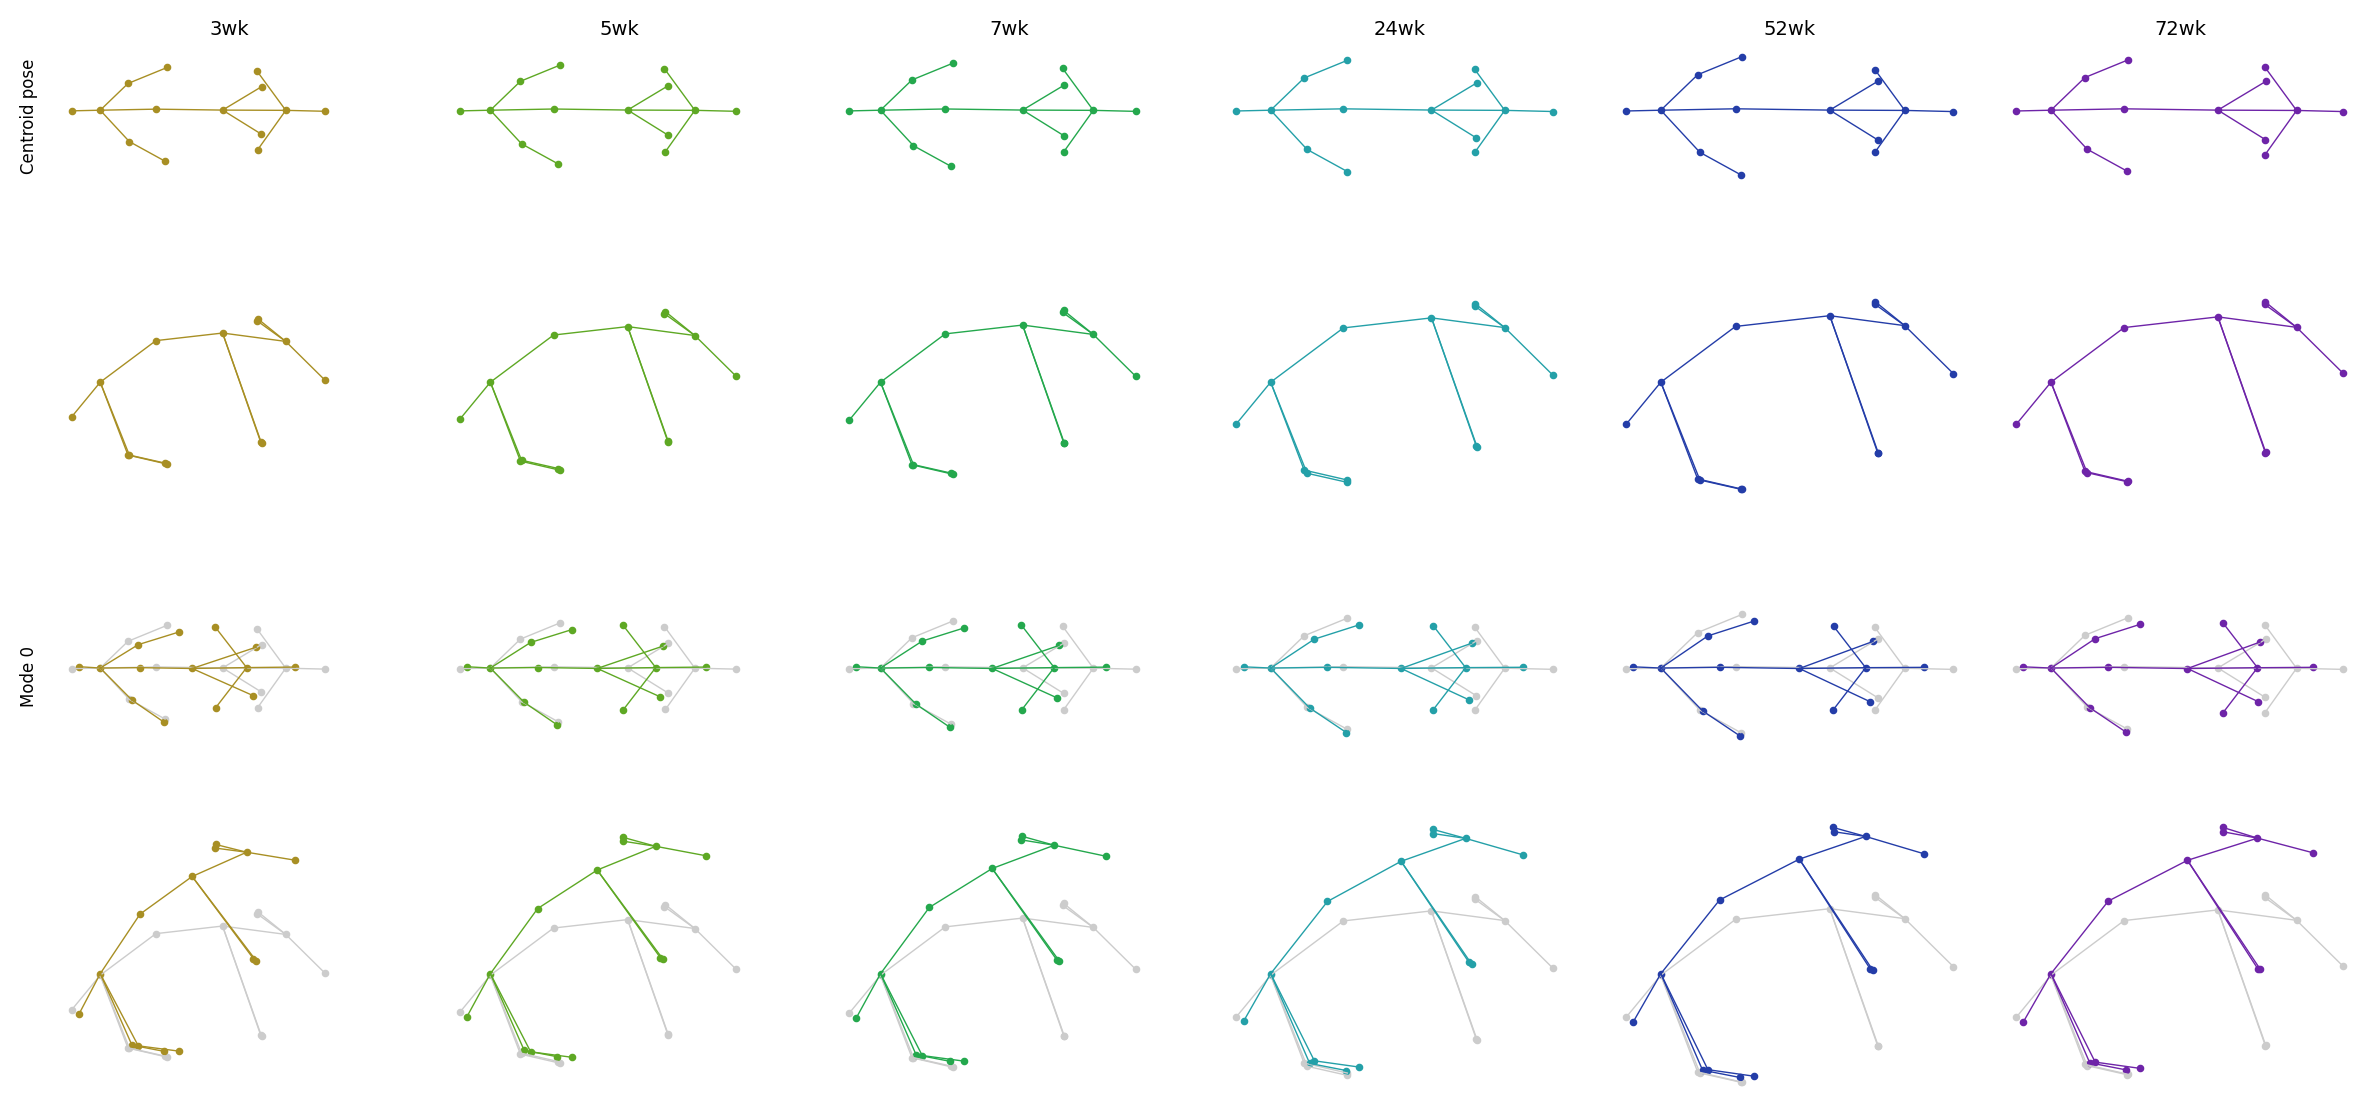

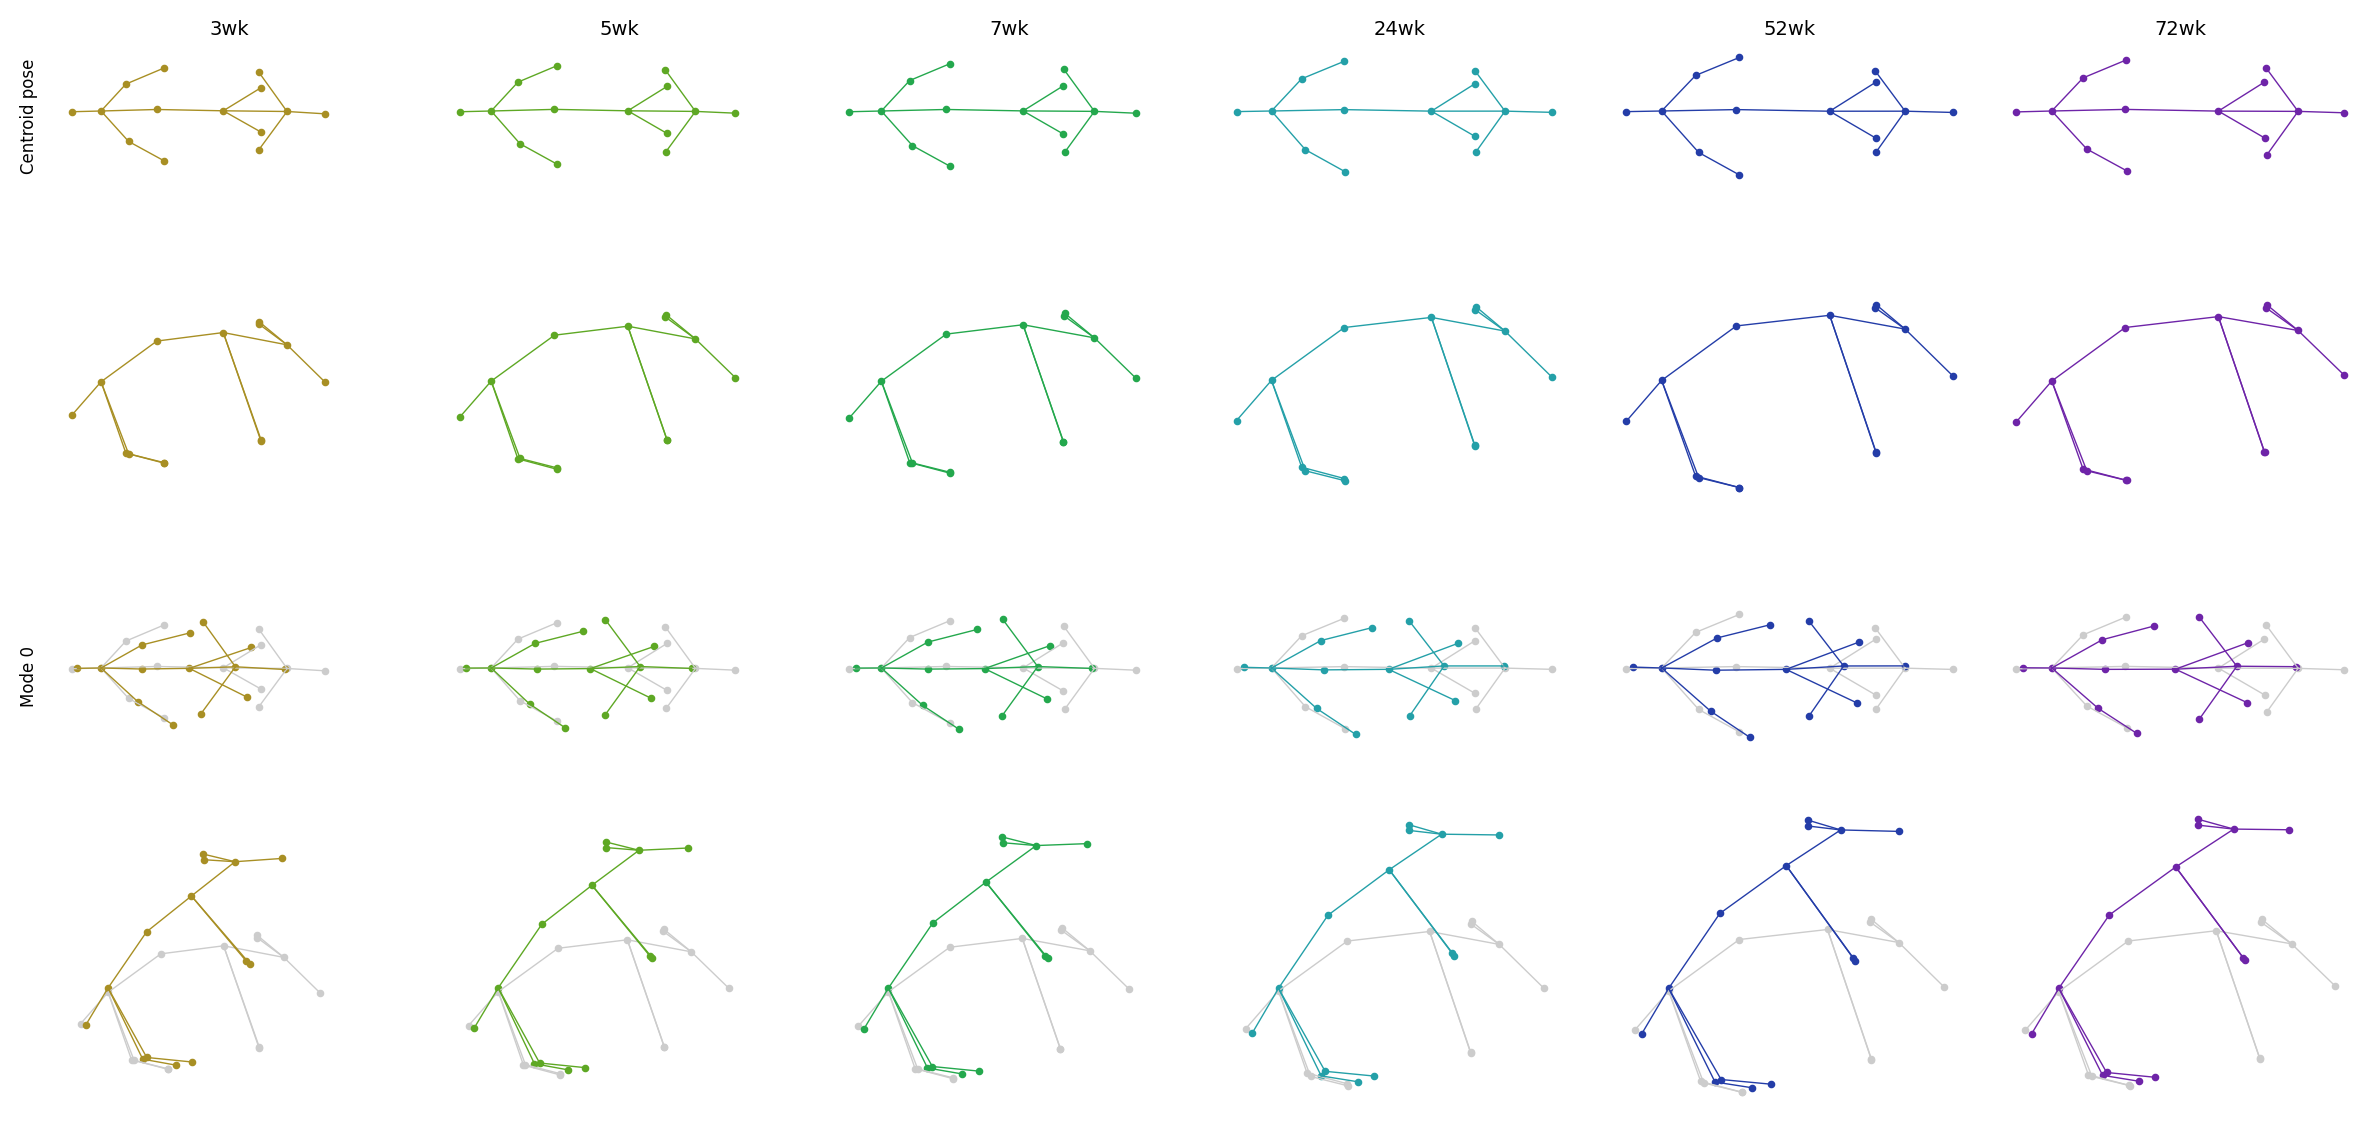

In [63]:
morph_model = afm.AffineModeMorph
gt_obs = pose.Observations(dataset['keypts'], dataset['subject_ids'])
metadata = dataset['metadata']

group_keys, groups = keypt_io.get_groups_dict(metadata[cfg['groupby']])
plot_subset = [group[0] for group in groups]

def plot_for_params(params):
    fig, ax = plt.subplots((params.morph.L * 2 + 2), len(plot_subset),
    figsize = (2 * len(plot_subset), 1.5 * (params.morph.L * 2 + 2)),
    sharex = 'row', sharey = 'row')

    age_pal = viz.defaults.age_pal(metadata[cfg['groupby']])

    all_poses = morph_model.inverse_transform(
            params.morph,
            dataset['keypts'],
            dataset['subject_ids'])
    quantiles = viz.affine_mode.mode_quantiles(params.morph, all_poses, 0.9)

    viz.affine_mode.mode_body_diagrams(
        params.morph, quantiles,
        metadata[cfg['groupby']], None,
        metadata['session_ix'],
        0, 1, plot_subset, age_pal,
        ax = ax[0::2])

    viz.affine_mode.mode_body_diagrams(
        params.morph, quantiles,
        metadata[cfg['groupby']], None,
        metadata['session_ix'],
        0, 2, plot_subset, age_pal,
        ax = ax[1::2], titles = False, label_suff = None)

    fig.tight_layout()
    return fig

plot_for_params(init); plt.show()
plot_for_params(fit['fit_params']); plt.show()


### Mode reconstruction

In [109]:
dataset = results['dataset']
fit = results['fit']
init = results['init']
cfg = dict(
    groupby = 'tgt_age',
    subj_id = 'src-id')

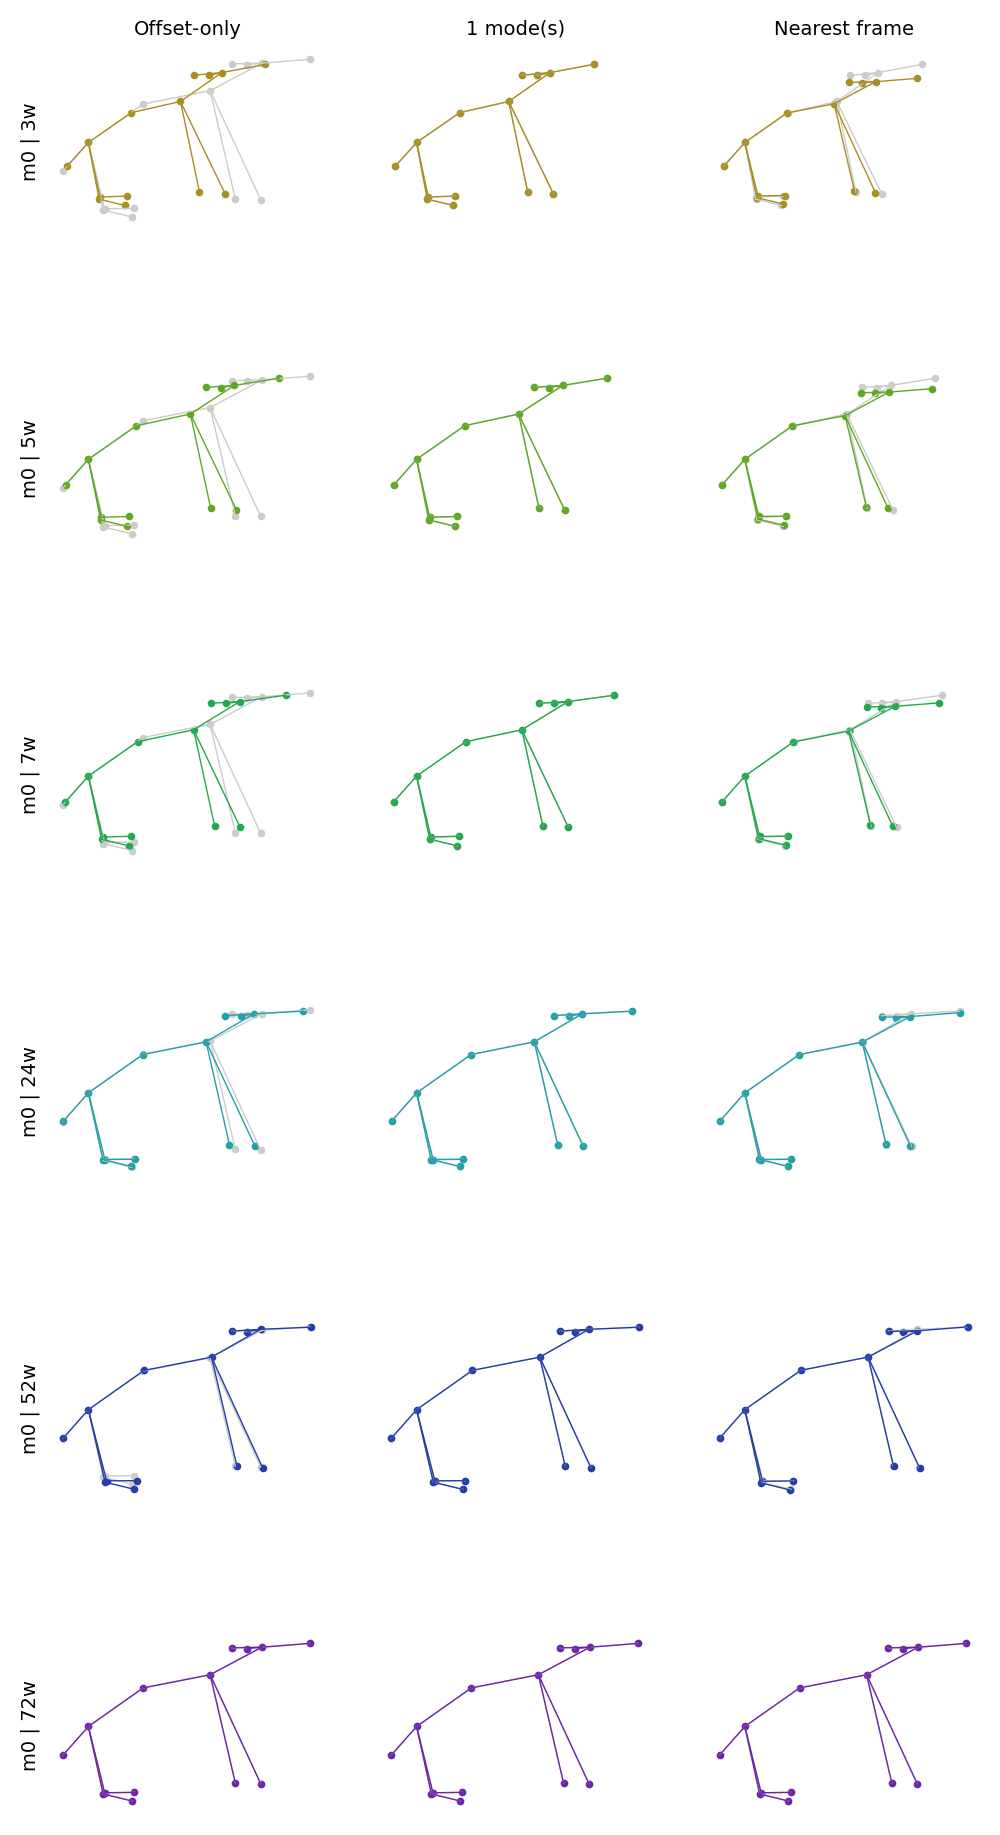

In [111]:
# plot_ref_frame = 13405
params = init
xaxis, yaxis = 0, 2
morph_model = afm.AffineModeMorph

group_keys, groups = keypt_io.get_groups_dict(metadata[cfg['groupby']])
plot_compare_subset = [group[0] for group in groups]

viz.affine_mode.mode_reconstruction_diagrams(
    plot_ref_frame,
    dataset['keypts'],
    init.morph,
    metadata[cfg['groupby']],
    metadata[cfg['subj_id']],
    metadata['session_ix'],
    dataset['subject_ids'],
    metadata['session_slice'],
    0, 2,
    plot_compare_subset
);

In [110]:
skel = skeleton.default_armature
head_heights = dataset['keypts'].reshape([-1, skel.n_kpts, 3])[:, skel.keypt_by_name['head'], 2]
plot_ref_frame = np.argsort(abs(head_heights - np.quantile(head_heights, 0.9)))[0]

In [94]:
plot_ref_frame

13405

### M-step parameter traces

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kpsn_test.visualize import fitting
from kpsn_test.visualize import defaults

In [108]:
dataset = results['dataset']
fit = results['fit']
cfg = dict(
    stepsize = 1,
    colorby = 'tgt_age'
    )

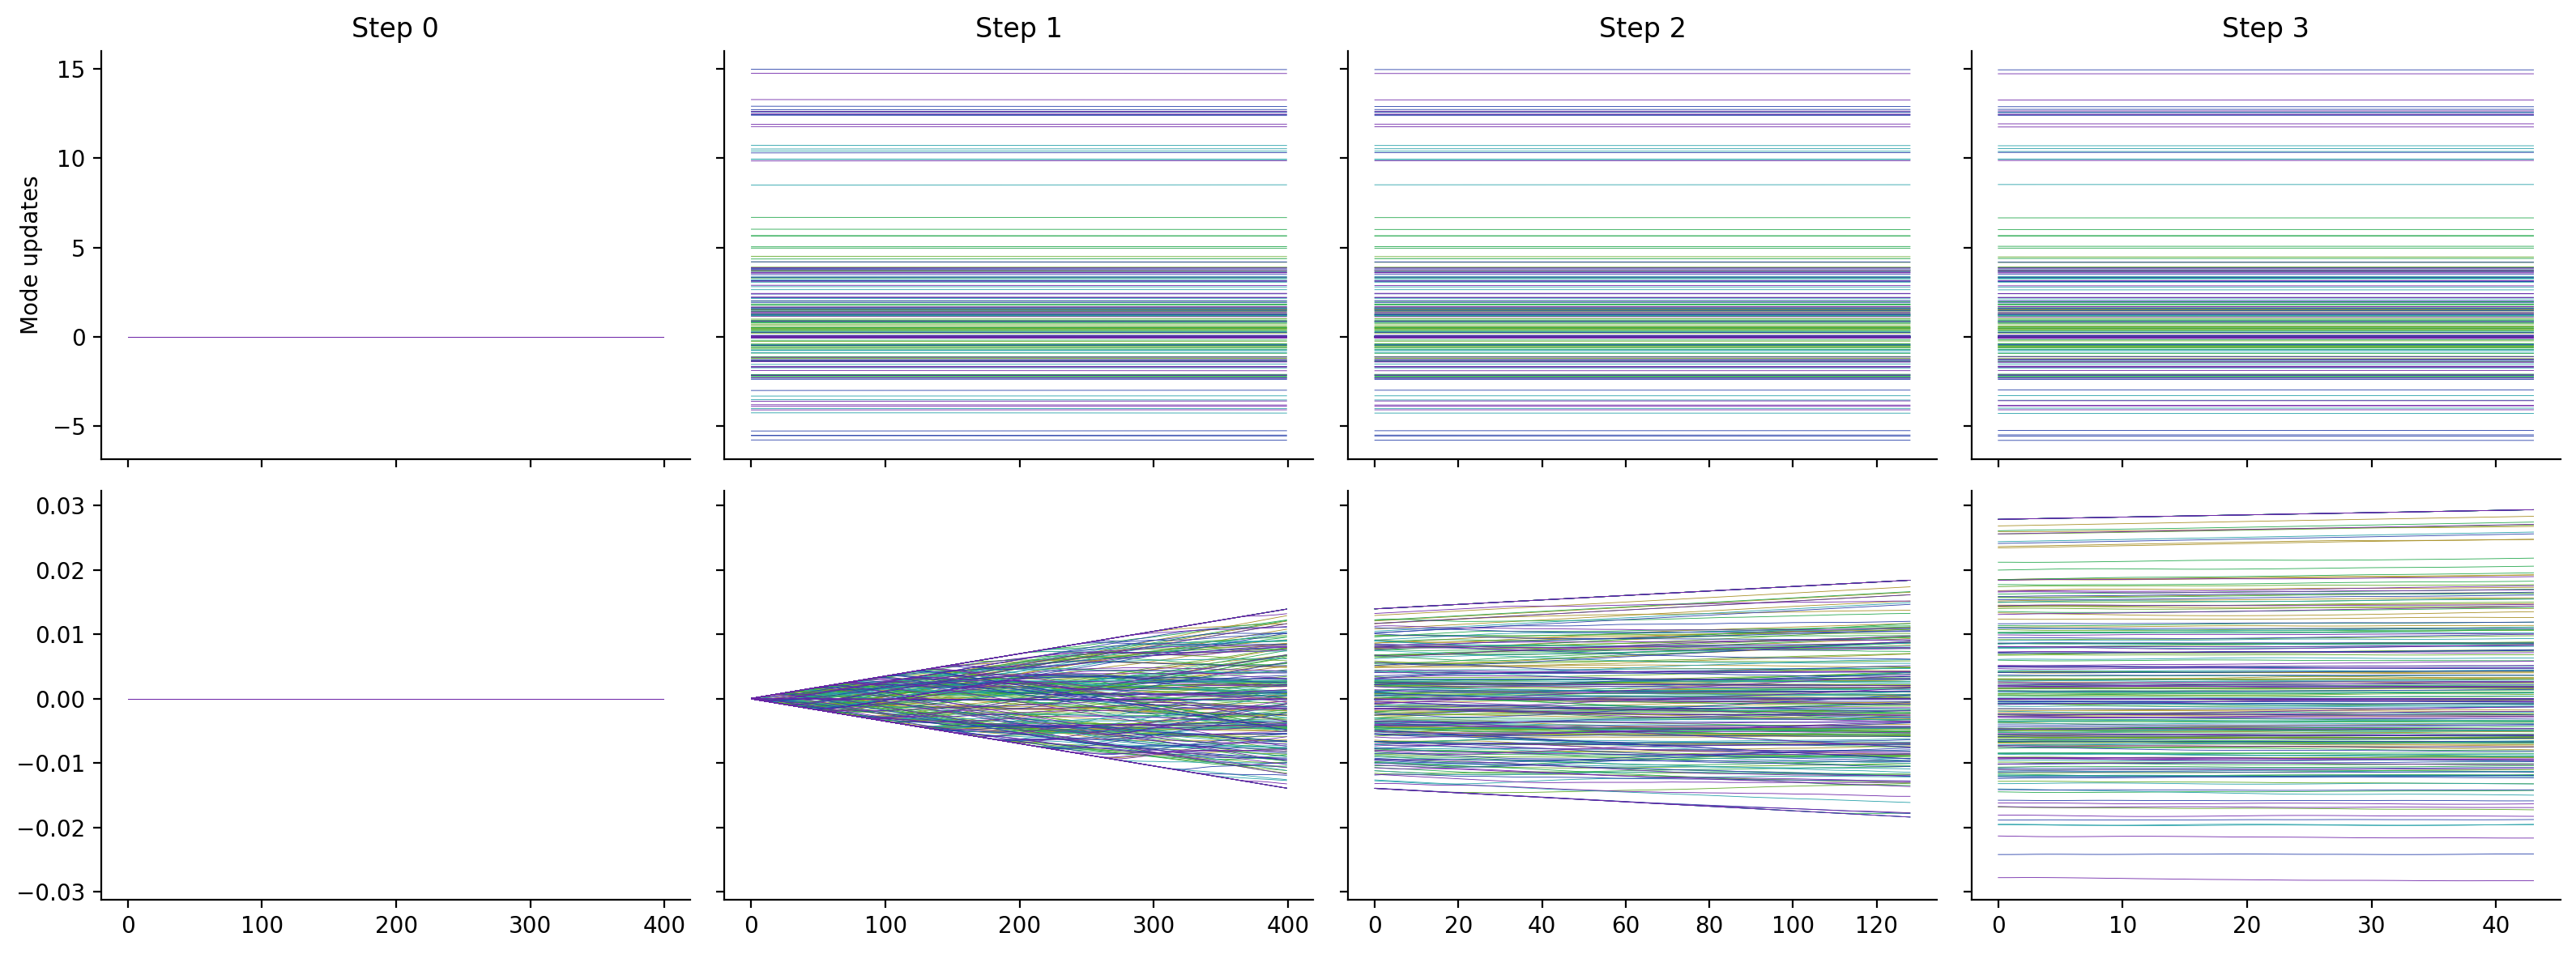

In [71]:
mstep_lengths = fitting.mstep_lengths(fit['mstep_losses'])
hyperparams = fit['fit_params'].hyperparams.morph
steps = np.arange(0, len(fit['mstep_losses']), cfg['stepsize'])
pal = defaults.age_pal(dataset['metadata'][cfg['colorby']])

fig, ax = plt.subplots(2, len(steps),
    figsize = (4 * len(steps), 3 * (hyperparams.L + 1)),
    sharex = 'col', sharey = 'row')

line_kw = dict(lw = 0.3)
for col, step in enumerate(steps):
    step_params = fit['param_hist'][step]
    for sess_i in range(hyperparams.N):
        sess_name = dataset['metadata']['session_ix'].inv[sess_i]
        sess_color = dataset['metadata'][cfg['colorby']][sess_name]
        step_len = mstep_lengths[step]
        ax[0, col].plot(
            step_params.morph.offset_updates[:step_len, sess_i],
            color = pal[sess_color], **line_kw)
        for mode_i in range(hyperparams.L):
            ax[mode_i + 1, col].plot(
                step_params.morph.mode_updates[:step_len, sess_i, :, mode_i],
                color = pal[sess_color], **line_kw)

    ax[0, col].set_title(f"Step {step}")


ax[0, 0].set_ylabel(f"Offset updates")
ax[1, 0].set_ylabel(f"Mode updates")
    
sns.despine()
plt.tight_layout()
plt.show()

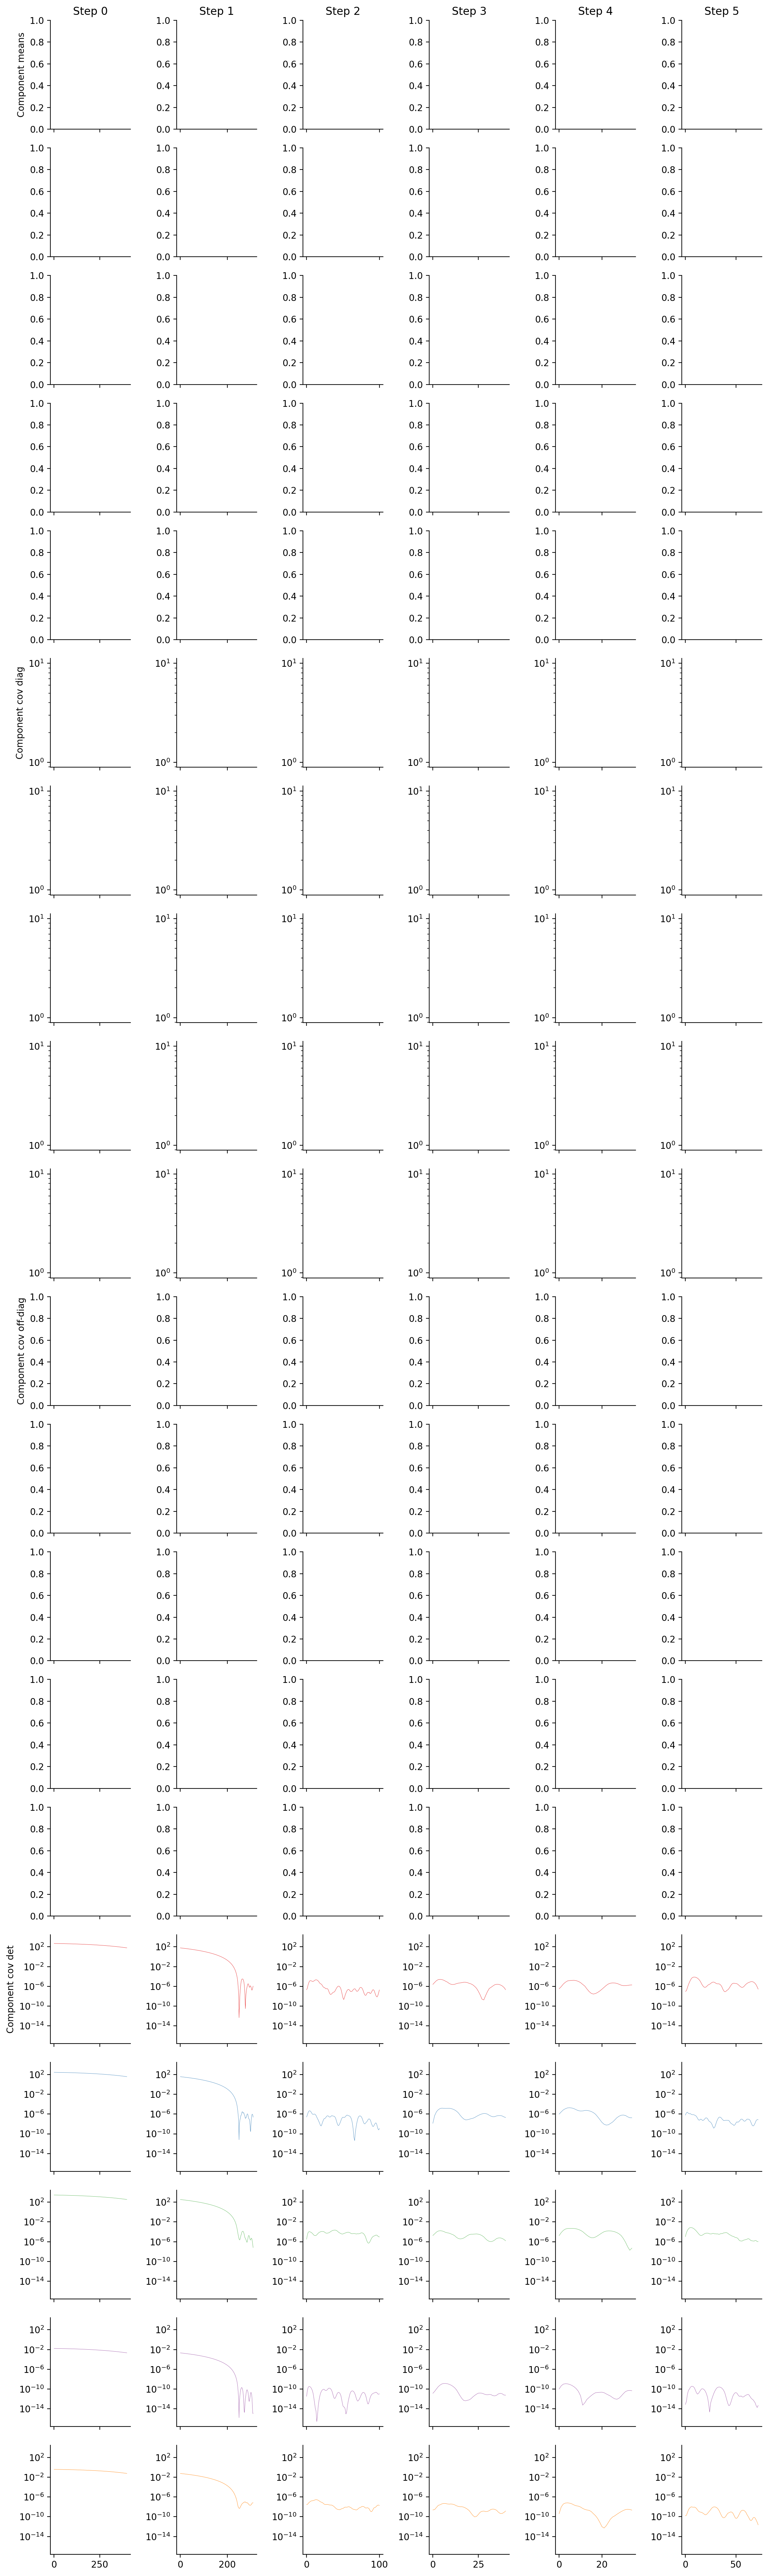

In [111]:
mstep_lengths = fitting.mstep_lengths(fit['mstep_losses'])
mstep_lengths = [m for m in mstep_lengths if m > 1]
hyperparams = fit['fit_params'].hyperparams.posespace
steps = np.arange(0, len(mstep_lengths), cfg['stepsize'])
pal = sns.color_palette('Set1', n_colors = hyperparams.L)

fig, ax = plt.subplots(4 * hyperparams.L, len(steps),
    figsize = (2 * len(steps), 4 * (hyperparams.L * 2)),
    sharex = 'col', sharey = False)

for col, step in enumerate(steps):
    for comp_i in range(hyperparams.L):
        if not (comp_i == 0 and col == 0):
            for i in range(4):
                ax[comp_i + i *  hyperparams.L, col].sharey(ax[i * hyperparams.L, 0])

line_kw = dict(lw = 0.3)
for col, step in enumerate(steps):
    step_params = fit['param_hist'][step]
    step_len = mstep_lengths[step]
    diag_mask = np.eye(hyperparams.M).astype('bool')
    for comp_i in range(hyperparams.L):
        # ax[comp_i, col].plot(
        #     step_params.posespace.means[:step_len, comp_i],
        #     color = pal[comp_i], **line_kw)
        # ax[comp_i + hyperparams.L, col].plot(
        #     step_params.posespace.with_hyperparams(hyperparams
        #         ).covariances()[:step_len, comp_i][:, diag_mask],
        #     color = pal[comp_i], **line_kw)
        # ax[comp_i + 2 * hyperparams.L, col].plot(
        #     step_params.posespace.with_hyperparams(hyperparams
        #         ).covariances()[:step_len, comp_i][:, ~diag_mask][:, ::51],
        #     color = pal[comp_i], **line_kw)
        ax[comp_i + 3 * hyperparams.L, col].plot(
            np.linalg.det(step_params.posespace.with_hyperparams(hyperparams
                ).covariances()[:step_len, comp_i]),
            color = pal[comp_i], **line_kw)
        
        ax[comp_i + hyperparams.L, col].set_yscale('log')
        ax[comp_i + 3 * hyperparams.L, col].set_yscale('log')
    ax[0, col].set_title(f"Step {step}")


ax[0, 0].set_ylabel(f"Component means")
ax[hyperparams.L, 0].set_ylabel(f"Component cov diag")
ax[2 * hyperparams.L, 0].set_ylabel(f"Component cov off-diag")
ax[3 * hyperparams.L, 0].set_ylabel(f"Component cov det")
    
sns.despine()
plt.tight_layout()
plt.show()

In [112]:
print(mstep_lengths)

[400, 311, 101, 41, 35, 73]
